In [2]:
import time
import numpy as np
import pandas as pd

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [3]:
train = pd.read_json('cooking_train.json')

def preprocessor(line):
    return ' '.join(line).lower()

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect =  TfidfVectorizer(preprocessor=preprocessor, tokenizer=LemmaTokenizer(),stop_words='english')
X_train = vect.fit_transform(train['ingredients'])
y_train = train['cuisine']

def benchmark(clf,name):
    print("Training: ")
    print(clf)
    t0 = time.time()
    res = cross_val_score(clf, X_train, y_train, n_jobs=-1)
    train_time = time.time() - t0
    print("cross_val time: %0.3fs" % train_time)
    score = sum(res) / len(res)
    print("accuracy:   %0.3f" % score)
    return  name, score, train_time

classifiers = [ 
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (RandomForestClassifier(), "Random forest"),
    (LinearSVC(dual=False, tol=1e-3), "LinearSVC"),
    (SGDClassifier(alpha=.0001, max_iter=50, penalty='l2'), "SGDClassifier with l2"),
    (SGDClassifier(alpha=.0001, max_iter=50, penalty='elasticnet'), "SGDClassifier with elasticnet"),
    (SVC(), "SVC"),
    (MultinomialNB(alpha=0.1),"MultinomialNB"),
    (BernoulliNB(alpha=0.1),"BernoulliNB"),
    (ComplementNB(alpha=0.1),"ComplementNB"),
    (LogisticRegression(max_iter=200),"LogisticRegression")
]
results = []

/home/abs/Projects/ML_JNP/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
for clf,name in classifiers:
    results.append(benchmark(clf,name))
  

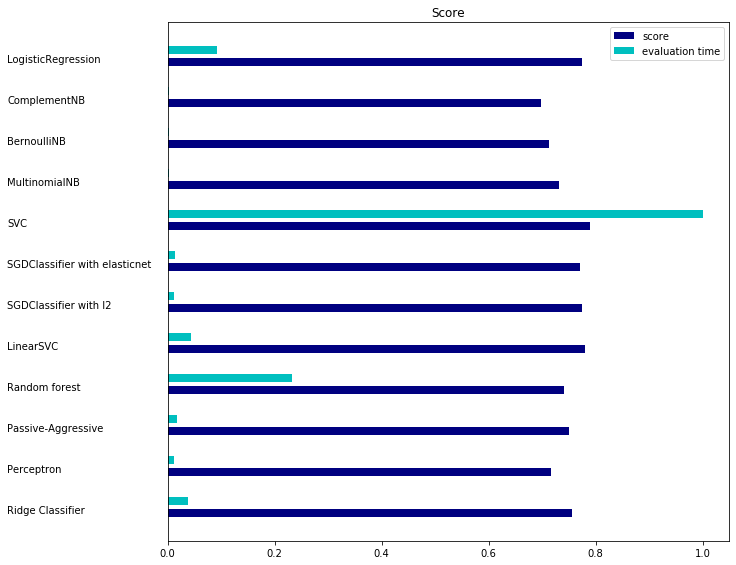

In [10]:
import matplotlib.pyplot as plt
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(3)]

clf_names, score, eval_time = results
eval_time = np.array(eval_time) / np.max(eval_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, eval_time, .2, label="evaluation time",
         color='c')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
plt.show()

In [6]:
from sklearn.ensemble import VotingClassifier

reg1 = SVC()
reg2 = LogisticRegression()
ereg =  VotingClassifier(estimators=[('svc', reg1), ('lg', reg2)])
ereg.fit(X_train,y_train)
res = cross_val_score(ereg, X_train, y_train,verbose=1,n_jobs=-1)
print(res)
sum(res) / len(res)

#GORSZY WYNIK NIŻ DLA SAMOGO SVC


/home/abs/Projects/ML_JNP/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


[0.78316667 0.78033333 0.78416667 0.78733333 0.78516667]


0.7840333333333332